In [1]:
import os
import sys
import numpy as np
import pandas as pd
#import pickle
import dill as pickle # https://stackoverflow.com/questions/25348532/can-python-pickle-lambda-functions
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import pyperclip
import joblib
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from utils import variables_mapping
from custom_transformers.transformers import PreProcessingTransformer, DropColumnsTransformer, CustomImputer, variables_mapping

In [2]:
df = pd.read_csv(os.path.join("data", "medicalencounter_202202142036.csv"))

In [3]:
df.dtypes

id                               int64
proba                          float64
prediction                        bool
true_label                      object
admission_id                   float64
patient_id                     float64
race                            object
gender                          object
age                             object
weight                          object
admission_type_code            float64
discharge_disposition_code     float64
admission_source_code            int64
time_in_hospital                 int64
payer_code                      object
medical_specialty               object
has_prosthesis                    bool
complete_vaccination_status     object
num_lab_procedures             float64
num_procedures                   int64
num_medications                float64
number_outpatient                int64
number_emergency                 int64
number_inpatient                 int64
diag_1                          object
diag_2                   

### Remove data without a true label

In [4]:
# Number of observations that did not get their true label
df['true_label'].isna().sum()

200

In [5]:
df = df[~df['true_label'].isna()]

### Calculate Metrics

In [6]:
y_pred = df['prediction'].astype(bool)

In [7]:
y_pred2 = df['proba'] > 0.38

In [8]:
y_true = df['true_label'].astype(bool)

###### Deployed thresold

In [9]:
accuracy_score(y_true, y_pred)

0.6806404044659785

In [10]:
precision_score(y_true, y_pred)

0.18131510416666666

In [11]:
recall_score(y_true, y_pred)

0.5186219739292365

In [12]:
f1_score(y_true, y_pred)

0.2686927158707188

###### Correct thresold

In [13]:
accuracy_score(y_true, y_pred2)

0.45807878660206447

In [14]:
precision_score(y_true, y_pred2)

0.1433327492553005

In [15]:
recall_score(y_true, y_pred2)

0.7616387337057728

In [16]:
f1_score(y_true, y_pred2)

0.2412623506857396

### Remove extra columns and create raw data

In [17]:
df['readmitted'] = df['true_label']

df = df.drop(['id', 'proba', 'true_label'], axis=1)

In [18]:
df.head()

,prediction,admission_id,patient_id,race,gender,age,weight,admission_type_code,discharge_disposition_code,admission_source_code,...,blood_type,hemoglobin_level,blood_transfusion,max_glu_serum,A1Cresult,diuretics,insulin,change,diabetesMed,readmitted
0,False,100706.0,12224646.0,Caucasian,Male,[40-50),?,2.0,1.0,1,...,A+,14.2,False,None,>8,No,Yes,No,Yes,False
1,True,99518.0,1020438.0,African American,Male,[60-70),?,2.0,18.0,2,...,O-,14.1,False,None,None,No,Yes,No,Yes,False
2,False,89397.0,141934014.0,AfricanAmerican,Female,[60-70),?,3.0,1.0,1,...,A+,13.4,False,NONE,None,No,Yes,No,Yes,False
3,True,89653.0,168821964.0,Caucasian,Male,[50-60),?,3.0,1.0,1,...,O-,15.3,False,None,None,Yes,Yes,Ch,Yes,False
4,False,83278.0,6485868.0,Hispanic,Male,[30-40),?,1.0,3.0,7,...,O+,14.6,True,None,None,No,Yes,Ch,Yes,False


In [19]:
#df.to_csv('data/week1_raw.csv')

In [20]:
# Create profile report
#ProfileReport(df, title="Week 1 raw data").to_file("reports/week1_raw.html")

### Preprocess data

In [21]:
known_categories = variables_mapping()

In [22]:
df_clean = df.copy()
for column in known_categories.keys():
    if column != 'readmitted':
        df_clean[column] = (df[column]
                            .apply(lambda value: known_categories[column]['mapping'](value))
                            .astype(known_categories[column]['type'])
                           )

In [23]:
#df_clean.to_csv('data/week1_preprocessed.csv')
#df_clean = pd.read_csv(os.path.join("data", "week1_preprocessed.csv"))

In [24]:
#ProfileReport(df_clean, title="Week 1 - Preprocessed data").to_file("reports/week1_preprocessed.html")

In [25]:
df_clean.dtypes

prediction                         bool
admission_id                    float64
patient_id                      float64
race                           category
gender                         category
age                               Int64
weight                            Int64
admission_type_code            category
discharge_disposition_code     category
admission_source_code          category
time_in_hospital                  int64
payer_code                     category
medical_specialty              category
has_prosthesis                     bool
complete_vaccination_status    category
num_lab_procedures                Int64
num_procedures                    int64
num_medications                   Int64
number_outpatient                 int64
number_emergency                  int64
number_inpatient                  int64
diag_1                         category
diag_2                         category
diag_3                         category
number_diagnoses                  int64


### Compare with old data

In [26]:
df_original = pd.read_csv(os.path.join("data", "preprocessed.csv"))

In [27]:
df_original.admission_id.values

array([    0,     1,     2, ..., 81409, 81410, 81411])

In [28]:
set(df_original.admission_id.values).intersection(df_clean.admission_id.values)

set()

In [29]:
df.medical_specialty.unique()

array(['Endocrinology', '?', 'Family/GeneralPractice', 'Radiologist',
       'Orthopedics', 'InternalMedicine', 'Emergency/Trauma',
       'Pulmonology', 'ObstetricsandGynecology', 'Surgeon', 'Cardiology',
       'Surgery-General', 'Pediatrics', 'Nephrology',
       'PhysicalMedicineandRehabilitation', 'Gastroenterology',
       'Surgery-Cardiovascular/Thoracic', 'Orthopedics-Reconstructive',
       'Hematology/Oncology', 'Surgery-Neuro', 'Psychiatry', 'Neurology',
       'Surgery-Vascular', 'Urology', 'Psychology', 'Hematology',
       'Surgery-Thoracic', 'Surgery-Cardiovascular',
       'Pediatrics-Endocrinology', 'Rheumatology', 'Oncology',
       'Pediatrics-Pulmonology', 'Otolaryngology', 'InfectiousDiseases',
       'DCPTEAM', 'Podiatry', 'Gynecology', 'Radiology', 'Hospitalist',
       'Surgery-Plastic', 'Surgery-PlasticwithinHeadandNeck',
       'Pediatrics-Neurology', 'SurgicalSpecialty', 'Osteopath',
       'Obstetrics', 'Anesthesiology', 'Ophthalmology',
       'Pediatrics-C

In [30]:
known_categories['medical_specialty']['dict'].keys()

dict_keys(['anesthesiology', 'anesthesiology-pediatric', 'cardiology', 'cardiology-pediatric', 'endocrinology', 'endocrinology-metabolism', 'hematology', 'hematology/oncology', 'obstetrics', 'obsterics&gynecology-gynecologicOnco', 'obstetricsandgynecology', 'obsterics&gynecology-gynecologiconco', 'gynecology', 'orthopedics', 'orthopedics-reconstructive', 'pediatrics', 'pediatrics-criticalcare', 'pediatrics-hematology-oncology', 'pediatrics-pulmonology', 'pediatrics-endocrinology', 'pediatrics-emergencymedicine', 'pediatrics-neurology', 'pediatrics-allergyandimmunology', 'physicalmedicineandrehabilitation', 'physiciannotfound', 'psychiatry', 'psychiatry-child/adolescent', 'psychology', 'psychiatry-addictive', 'radiologist', 'radiology', 'surgeon', 'surgery-cardiovascular', 'surgery-cardiovascular/thoracic', 'surgery-colon&rectal', 'surgery-general', 'surgery-maxillofacial', 'surgery-neuro', 'surgery-pediatric', 'surgery-plastic', 'surgery-thoracic', 'surgery-vascular', 'surgicalspecialt

In [31]:
for specialty in df.medical_specialty.unique():
    if specialty.lower() not in known_categories['medical_specialty']['dict'].keys():
        print(specialty.lower())


?
surgery-plasticwithinheadandneck


In [32]:
df[df.medical_specialty == 'Surgery-PlasticwithinHeadandNeck']

,prediction,admission_id,patient_id,race,gender,age,weight,admission_type_code,discharge_disposition_code,admission_source_code,...,blood_type,hemoglobin_level,blood_transfusion,max_glu_serum,A1Cresult,diuretics,insulin,change,diabetesMed,readmitted
2209,False,88332.0,115864254.0,European,Male,[40-50),?,6.0,1.0,1,...,AB+,14.4,False,NONE,None,No,No,No,Yes,False


In [33]:
df.medical_specialty.isna().sum()

0

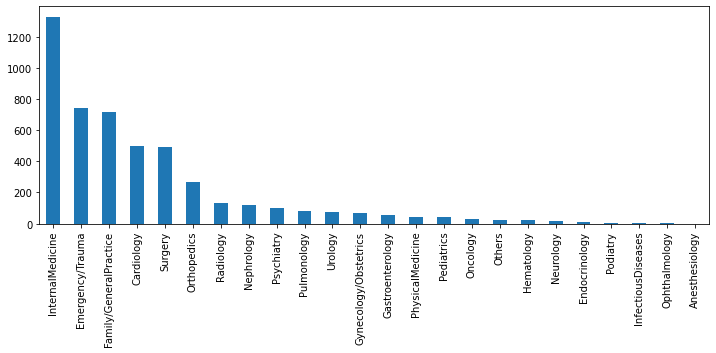

In [34]:
df_clean[df.medical_specialty != '?'].medical_specialty.value_counts().plot(kind='bar', figsize=(12, 4));
plt.savefig("images/week1_medical_specialty_cardinality.pdf")

In [35]:
df_clean.prediction

0       False
1        True
2       False
3        True
4       False
        ...  
9689    False
9690     True
9691    False
9692    False
9693     True
Name: prediction, Length: 9494, dtype: bool

In [85]:
def get_descrimination_dict(df_, sensitive_columns=['age', 'race', 'gender', 'is_insured', 'medical_specialty'], target='readmitted'):
    """ 
    """
    
    specialties = df_['medical_specialty'].unique()
        
    result = {}
    for sensitive_column in sensitive_columns:
        classes = sorted([ str(x) for x in df_[sensitive_column].unique() ])        
        
        result[sensitive_column] = {}
        #result[sensitive_column]['classes_order'] = classes # Preserve the order we iterate through sensitive class
        to_remove = ['Anesthesiology', 'Endocrinology', 'Gynecology/Obstetrics', 'Neurology', 'Ophthalmology', 'InfectiousDiseases', 'Podiatry', 'unknown']
        
        for class_ in classes:
            if class_ not in to_remove:
                medical_encounters = df_[(df_[sensitive_column] == class_)]

                y_true = medical_encounters.readmitted.astype(bool)
                y_pred = medical_encounters.prediction.astype(bool)

                precision = precision_score(y_true, y_pred, labels=[True])

                result[sensitive_column][class_] = precision
    
    return result
        
# print(json.dumps(verify_descrimination(df)))

In [86]:
df_clean['is_insured'] = df_clean.payer_code.fillna('BC').apply(lambda x: 'insured' if np.nan_to_num(x) == 'SP' else 'not insured').astype('category')
df_clean['age'] = df_clean.age.apply(lambda x: str(x)).astype('category')
dict_ = get_descrimination_dict(df_clean)

In [89]:
def plot_dict(D, name):
    plt.bar(range(len(D)), list(D.values()), align='center')
    plt.xticks(range(len(D)), list(D.keys()))

    plt.ylabel("Precision - Readmission Rate")
    plt.gcf().set_size_inches(6,4)
    #plt.gcf().set_size_inches(12,4)
    #plt.xticks(rotation=90)
    
    plt.gcf().savefig("images/week1/discrimination_requirement_" + sensitive_column + ".pdf")

    plt.show()

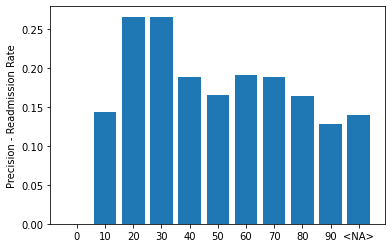

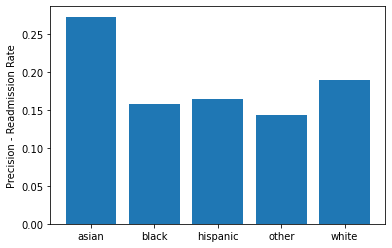

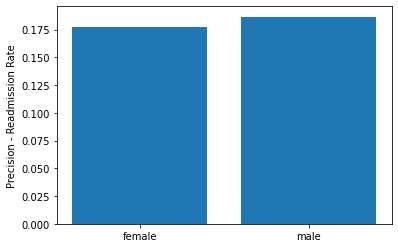

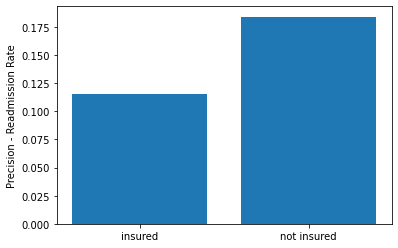

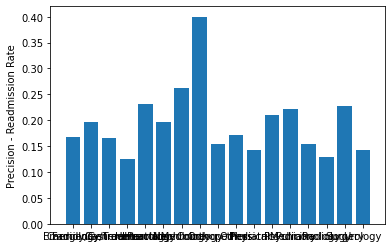

In [90]:
for sensitive_column in ['age', 'race', 'gender', 'is_insured', 'medical_specialty']:
    plot_dict(dict_[sensitive_column], sensitive_column)

#plot_dict(dict_['medical_specialty'], 'medical_specialty')

to_remove = ['Anesthesiology', 'Endocrinology', 'Gynecology/Obstetrics', 'Neurology', 'Ophthalmology', 'InfectiousDiseases']

In [93]:
for sensitive_column in ['age', 'race', 'gender', 'is_insured', 'medical_specialty']:
    values = dict_[sensitive_column].values()
    min_ = min(values)
    max_ = max(values)
    print(sensitive_column + ' - ' + str(max_-min_))

age - 0.2653061224489796
race - 0.12987012987012986
gender - 0.009421993935268269
is_insured - 0.06884380065889242
medical_specialty - 0.275
